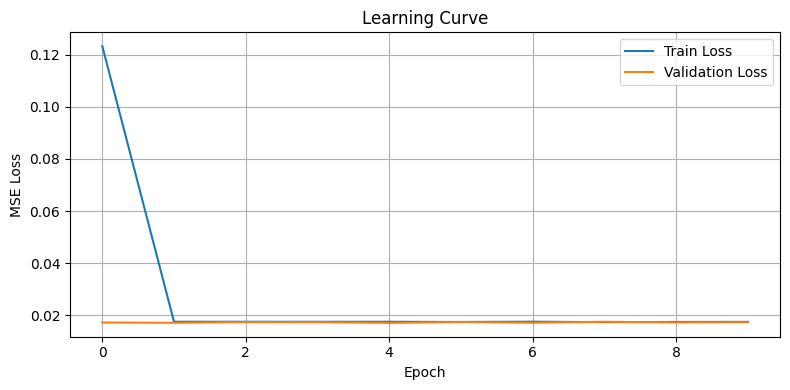

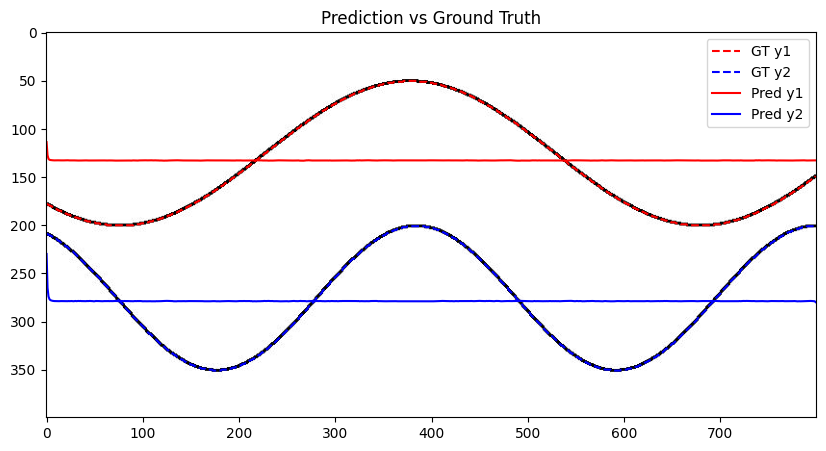

In [5]:
# CNN + LSTM for Seismogram Curve Extraction

import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
from tqdm import tqdm
from IPython.display import clear_output

# Paths
source_directory = "D:/Courses/Uclouvain/thesis/code/thesis_Colin/seismogram_curve_extraction/data_2_traces/sines/overlap_0-00/"
signals_directory = os.path.join(source_directory, "signals")
gts_directory = os.path.join(source_directory, "ground_truth")

# Load images
def load_images_from_folder(folder):
    images = []
    for file_name in sorted(os.listdir(folder)):
        img = cv2.imread(os.path.join(folder, file_name), cv2.IMREAD_GRAYSCALE)
        images.append(img)
    return np.array(images)

saved_images = load_images_from_folder(signals_directory)  # Shape: (1000, 400, 800)

# Load GTs
def load_ground_truths(folder):
    file_list = sorted([f for f in os.listdir(folder) if f.endswith(".npy")])
    GTs = [np.load(os.path.join(folder, f)) for f in file_list]
    return np.stack(GTs)

GTs = load_ground_truths(gts_directory)  # Shape: (1000, 2, 800)
GTs = np.transpose(GTs, (0, 2, 1))  # Shape: (1000, 800, 2)

# Dataset class
class SeismoDataset(Dataset):
    def __init__(self, images, ground_truths):
        self.images = images
        self.gts = ground_truths
        self.transform = transforms.ToTensor()

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.transform(self.images[idx]) / 255.0  # Normalize input to [0, 1]
        gt = self.gts[idx] / self.images[idx].shape[0]  # Normalize GT y-values to [0, 1]
        return img, torch.tensor(gt, dtype=torch.float32)

# CNN + LSTM model
class CNNLSTMModel(nn.Module):
    def __init__(self, input_height, embedding_dim=64, hidden_dim=64):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            nn.Conv2d(16, embedding_dim, kernel_size=(input_height, 1)),
            nn.ReLU()
        )
        self.lstm = nn.LSTM(input_size=embedding_dim, hidden_size=hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 2)  # Removed Sigmoid for manual clamping

    def forward(self, x):
        B, _, H, W = x.size()
        x = self.encoder(x).squeeze(2).permute(0, 2, 1)  # [B, W, D]
        x, _ = self.lstm(x)
        return torch.clamp(self.fc(x), 0, 1)  # Manually clamp output to [0, 1]

# Initialize training components
H, W = saved_images.shape[1], saved_images.shape[2]
dataset = SeismoDataset(saved_images, GTs)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNLSTMModel(input_height=H).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Training loop with live plotting
num_epochs = 10
train_losses, val_losses = [], []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for imgs, gts in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
        imgs, gts = imgs.to(device), gts.to(device)
        optimizer.zero_grad()
        preds = model(imgs)
        loss = criterion(preds, gts)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_losses.append(running_loss / len(train_loader))

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for imgs, gts in val_loader:
            imgs, gts = imgs.to(device), gts.to(device)
            preds = model(imgs)
            val_loss += criterion(preds, gts).item()
    val_losses.append(val_loss / len(val_loader))

    # Live plot
    clear_output(wait=True)
    plt.figure(figsize=(8, 4))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel("Epoch")
    plt.ylabel("MSE Loss")
    plt.title("Learning Curve")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Inference and visualization
model.eval()
with torch.no_grad():
    test_img = torch.tensor(saved_images[0:1], dtype=torch.float32) / 255.0
    test_img = test_img.unsqueeze(1).to(device)  # [1, 1, H, W]
    prediction = model(test_img)[0].cpu().numpy() * H  # Denormalize output to pixel space

# Plot predicted vs ground truth
plt.figure(figsize=(12, 5))
plt.imshow(saved_images[0], cmap='gray')
plt.plot(np.arange(W), GTs[0, :, 0], 'r--', label='GT y1')
plt.plot(np.arange(W), GTs[0, :, 1], 'b--', label='GT y2')
plt.plot(np.arange(W), prediction[:, 0], 'r-', label='Pred y1')
plt.plot(np.arange(W), prediction[:, 1], 'b-', label='Pred y2')
plt.legend()
plt.title("Prediction vs Ground Truth")
plt.show()



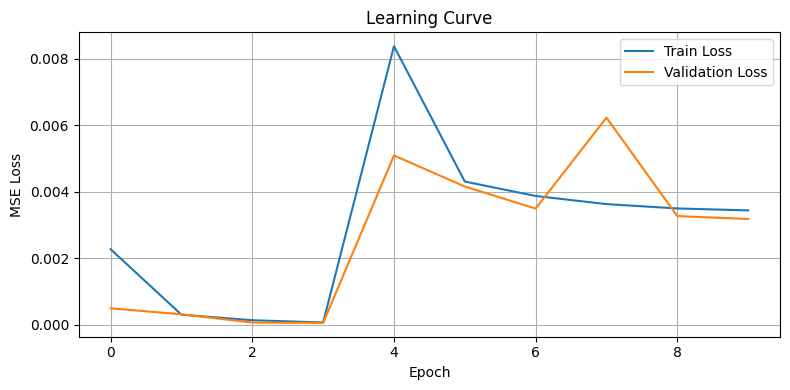

In [6]:
# CNN + LSTM for Seismogram Curve Extraction (Patch-wise RNN with Reduced Parameters)

import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
from tqdm import tqdm
from IPython.display import clear_output

# Paths
source_directory = "D:/Courses/Uclouvain/thesis/code/thesis_Colin/seismogram_curve_extraction/data_2_traces/sines/overlap_0-00/"
signals_directory = os.path.join(source_directory, "signals")
gts_directory = os.path.join(source_directory, "ground_truth")

# Load images
def load_images_from_folder(folder):
    images = []
    for file_name in sorted(os.listdir(folder)):
        img = cv2.imread(os.path.join(folder, file_name), cv2.IMREAD_GRAYSCALE)
        images.append(img)
    return np.array(images)

saved_images = load_images_from_folder(signals_directory)

# Load GTs
def load_ground_truths(folder):
    file_list = sorted([f for f in os.listdir(folder) if f.endswith(".npy")])
    GTs = [np.load(os.path.join(folder, f)) for f in file_list]
    return np.stack(GTs)

GTs = load_ground_truths(gts_directory)
GTs = np.transpose(GTs, (0, 2, 1))  # [N, W, 2]

# Parameters
H, W = saved_images.shape[1], saved_images.shape[2]
patch_width = 11  # width of vertical window
half_patch = patch_width // 2

# Dataset class (patch-wise)
class PatchwiseSeismoDataset(Dataset):
    def __init__(self, images, ground_truths, patch_width):
        self.images = images
        self.gts = ground_truths
        self.patch_width = patch_width
        self.transform = transforms.ToTensor()

    def __len__(self):
        return len(self.images) * (self.images.shape[2] - self.patch_width + 1)

    def __getitem__(self, idx):
        img_idx = idx // (self.images.shape[2] - self.patch_width + 1)
        col_idx = idx % (self.images.shape[2] - self.patch_width + 1)

        img = self.images[img_idx][:, col_idx:col_idx+self.patch_width] / 255.0
        img_patch = torch.tensor(img, dtype=torch.float32).unsqueeze(0)  # [1, H, patch_width]
        center_col = col_idx + self.patch_width // 2
        gt = self.gts[img_idx, center_col] / H  # [2] normalized y-positions

        return img_patch, torch.tensor(gt, dtype=torch.float32)

# Simple patch encoder + RNN
class PatchRNNModel(nn.Module):
    def __init__(self, input_height, patch_width, embedding_dim=16, hidden_dim=32):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, embedding_dim, kernel_size=(input_height, patch_width)),
            nn.ReLU()
        )
        self.rnn = nn.LSTM(input_size=embedding_dim, hidden_size=hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 2)

    def forward(self, x_seq):
        B, T, C, H, W = x_seq.size()  # [B, T, 1, H, W]
        x_seq = x_seq.view(B * T, C, H, W)
        x = self.encoder(x_seq).squeeze(-1).squeeze(-1)  # [B*T, D]
        x = x.view(B, T, -1)  # [B, T, D]
        out, _ = self.rnn(x)
        return torch.clamp(self.fc(out), 0, 1)  # [B, T, 2]

# Prepare patchwise dataset
dataset = PatchwiseSeismoDataset(saved_images, GTs, patch_width)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)

# Model setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
model = PatchRNNModel(input_height=H, patch_width=patch_width).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Training loop
num_epochs = 10
train_losses, val_losses = [], []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for x, y in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
        x, y = x.to(device), y.to(device)
        x = x.unsqueeze(1)  # [B, T=1, C, H, W]
        pred = model(x).squeeze(1)
        loss = criterion(pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_losses.append(train_loss / len(train_loader))

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            x = x.unsqueeze(1)
            pred = model(x).squeeze(1)
            loss = criterion(pred, y)
            val_loss += loss.item()
    val_losses.append(val_loss / len(val_loader))

    clear_output(wait=True)
    plt.figure(figsize=(8, 4))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel("Epoch")
    plt.ylabel("MSE Loss")
    plt.title("Learning Curve")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


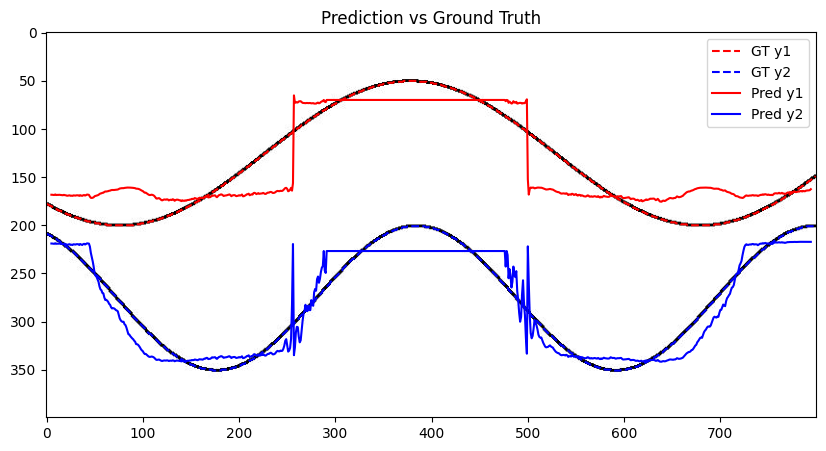

In [8]:
# Inference and visualization
model.eval()
predicted_positions = []
with torch.no_grad():
    for col in range(W - patch_width + 1):
        patch = saved_images[0][:, col:col + patch_width] / 255.0  # shape: [H, patch_width]
        patch_tensor = torch.tensor(patch, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)  # [1, 1, H, W]
        pred = model(patch_tensor.unsqueeze(1))  # [1, 1, 2]
        predicted_positions.append(pred.squeeze(0).squeeze(0).cpu().numpy())

predicted_positions = np.array(predicted_positions) * H  # denormalize to pixel space
center_columns = np.arange(half_patch, W - half_patch)

# Plot predicted vs ground truth
plt.figure(figsize=(12, 5))
plt.imshow(saved_images[0], cmap='gray')
plt.plot(np.arange(W), GTs[0, :, 0], 'r--', label='GT y1')
plt.plot(np.arange(W), GTs[0, :, 1], 'b--', label='GT y2')
plt.plot(center_columns, predicted_positions[:, 0], 'r-', label='Pred y1')
plt.plot(center_columns, predicted_positions[:, 1], 'b-', label='Pred y2')
plt.legend()
plt.title("Prediction vs Ground Truth")
plt.show()

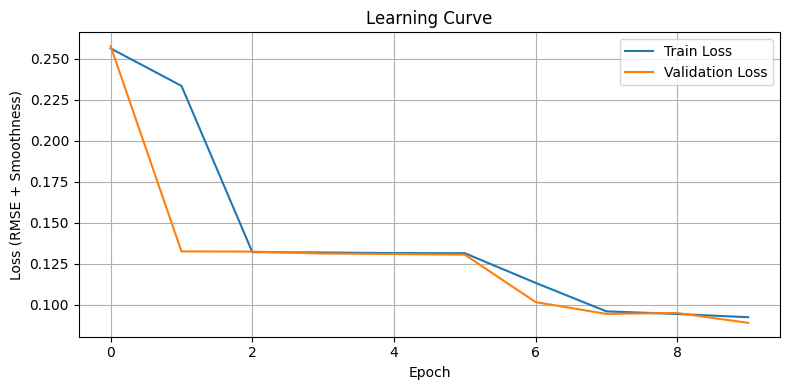

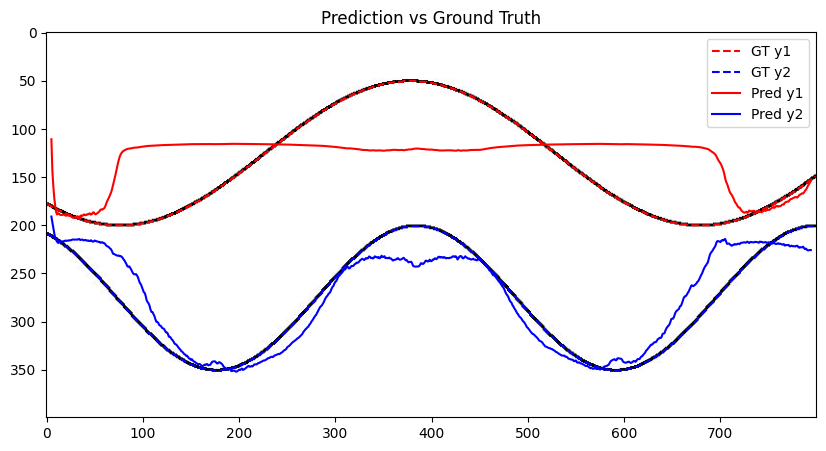

In [1]:
# CNN + LSTM for Seismogram Curve Extraction (Patch-wise RNN with Reduced Parameters)

import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
from tqdm import tqdm
from IPython.display import clear_output

# Paths
source_directory = "D:/Courses/Uclouvain/thesis/code/thesis_Colin/seismogram_curve_extraction/data_2_traces/sines/overlap_0-00/"
signals_directory = os.path.join(source_directory, "signals")
gts_directory = os.path.join(source_directory, "ground_truth")

# Load images
def load_images_from_folder(folder):
    images = []
    for file_name in sorted(os.listdir(folder)):
        img = cv2.imread(os.path.join(folder, file_name), cv2.IMREAD_GRAYSCALE)
        images.append(img)
    return np.array(images)

saved_images = load_images_from_folder(signals_directory)

# Load GTs
def load_ground_truths(folder):
    file_list = sorted([f for f in os.listdir(folder) if f.endswith(".npy")])
    GTs = [np.load(os.path.join(folder, f)) for f in file_list]
    return np.stack(GTs)

GTs = load_ground_truths(gts_directory)
GTs = np.transpose(GTs, (0, 2, 1))  # [N, W, 2]

# Parameters
H, W = saved_images.shape[1], saved_images.shape[2]
patch_width = 11  # width of vertical window
half_patch = patch_width // 2
lambda_smooth = 0.1

# Dataset class (full image)
class FullSeismoDataset(Dataset):
    def __init__(self, images, ground_truths):
        self.images = images
        self.gts = ground_truths

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx] / 255.0
        img_tensor = torch.tensor(img, dtype=torch.float32).unsqueeze(0)  # [1, H, W]
        gt = self.gts[idx] / H  # normalize
        return img_tensor, torch.tensor(gt, dtype=torch.float32)

# Simple patch encoder + RNN
class PatchRNNModel(nn.Module):
    def __init__(self, input_height, patch_width, embedding_dim=16, hidden_dim=32):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, embedding_dim, kernel_size=(input_height, patch_width)),
            nn.ReLU()
        )
        self.rnn = nn.LSTM(input_size=embedding_dim, hidden_size=hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 2)

    def forward(self, x_seq):
        B, C, H, W = x_seq.size()
        patches = []
        for i in range(W - patch_width + 1):
            patch = x_seq[:, :, :, i:i+patch_width]  # [B, 1, H, patch_width]
            encoded = self.encoder(patch).squeeze(-1).squeeze(-1)  # [B, D]
            patches.append(encoded)
        seq = torch.stack(patches, dim=1)  # [B, T, D]
        out, _ = self.rnn(seq)
        return torch.clamp(self.fc(out), 0, 1)  # [B, T, 2]

# Prepare dataset
dataset = FullSeismoDataset(saved_images, GTs)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

# Model setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = PatchRNNModel(input_height=H, patch_width=patch_width).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Training loop with RMSE and smoothness regularization
num_epochs = 10
train_losses, val_losses = [], []

for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0.0
    for x, y in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        B, C, H_img, W_img = x.size()
        predictions = []
        for i in range(W_img - patch_width + 1):
            patch = x[:, :, :, i:i+patch_width]  # [B, 1, H, patch_width]
            encoded = model.encoder(patch).squeeze(-1).squeeze(-1)  # [B, D]
            if i == 0:
                sequence = encoded.unsqueeze(1)
            else:
                sequence = torch.cat((sequence, encoded.unsqueeze(1)), dim=1)  # [B, T, D]

        output, _ = model.rnn(sequence)
        prediction = torch.clamp(model.fc(output), 0, 1)  # [B, T, 2]

        y_crop = y[:, half_patch:W - half_patch, :]  # [B, T, 2]
        rmse_loss = torch.sqrt(((prediction - y_crop) ** 2).mean())
        smoothness_loss = torch.mean((prediction[:, 1:] - prediction[:, :-1]) ** 2)
        loss = rmse_loss + lambda_smooth * smoothness_loss

        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()

    train_losses.append(total_train_loss / len(train_loader))

    model.eval()
    total_val_loss = 0.0
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            prediction = model(x)
            y_crop = y[:, half_patch:W - half_patch, :]
            rmse_loss = torch.sqrt(((prediction - y_crop) ** 2).mean())
            smoothness_loss = torch.mean((prediction[:, 1:] - prediction[:, :-1]) ** 2)
            loss = rmse_loss + lambda_smooth * smoothness_loss
            total_val_loss += loss.item()

    val_losses.append(total_val_loss / len(val_loader))

    clear_output(wait=True)
    plt.figure(figsize=(8, 4))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel("Epoch")
    plt.ylabel("Loss (RMSE + Smoothness)")
    plt.title("Learning Curve")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Inference and visualization
model.eval()
predicted_positions = []
with torch.no_grad():
    img = saved_images[0:1] / 255.0
    img_tensor = torch.tensor(img, dtype=torch.float32).unsqueeze(1).to(device)
    prediction = model(img_tensor)[0].cpu().numpy() * H
    predicted_positions = prediction
    center_columns = np.arange(half_patch, W - half_patch)

# Plot predicted vs ground truth
plt.figure(figsize=(12, 5))
plt.imshow(saved_images[0], cmap='gray')
plt.plot(np.arange(W), GTs[0, :, 0], 'r--', label='GT y1')
plt.plot(np.arange(W), GTs[0, :, 1], 'b--', label='GT y2')
plt.plot(center_columns, predicted_positions[:, 0], 'r-', label='Pred y1')
plt.plot(center_columns, predicted_positions[:, 1], 'b-', label='Pred y2')
plt.legend()
plt.title("Prediction vs Ground Truth")
plt.show()


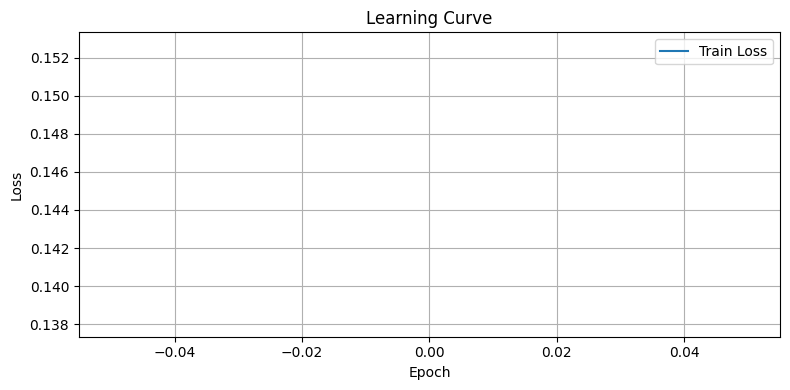

In [ ]:
# CNN + Custom RNN with Hungarian Matching for Curve Tracking

import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
from tqdm import tqdm
from IPython.display import clear_output
from scipy.optimize import linear_sum_assignment

# Paths
source_directory = "D:/Courses/Uclouvain/thesis/code/thesis_Colin/seismogram_curve_extraction/data_2_traces/sines/overlap_0-00/"
signals_directory = os.path.join(source_directory, "signals")
gts_directory = os.path.join(source_directory, "ground_truth")

# Load images
def load_images_from_folder(folder):
    images = []
    for file_name in sorted(os.listdir(folder)):
        img = cv2.imread(os.path.join(folder, file_name), cv2.IMREAD_GRAYSCALE)
        images.append(img)
    return np.array(images)

saved_images = load_images_from_folder(signals_directory)

# Load GTs
def load_ground_truths(folder):
    file_list = sorted([f for f in os.listdir(folder) if f.endswith(".npy")])
    GTs = [np.load(os.path.join(folder, f)) for f in file_list]
    return np.stack(GTs)

GTs = load_ground_truths(gts_directory)
GTs = np.transpose(GTs, (0, 2, 1))  # [N, W, 2]

# Parameters
H, W = saved_images.shape[1], saved_images.shape[2]
lambda_smooth = 0.1

N_curves = GTs.shape[2]
input_size = N_curves
hidden_size = 2 * N_curves
output_size = 2 * N_curves

# Dataset
class FullSeismoDataset(Dataset):
    def __init__(self, images, ground_truths):
        self.images = images
        self.gts = ground_truths

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx] / 255.0
        image_tensor = torch.tensor(image, dtype=torch.float32).unsqueeze(0)  # [1, H, W]
        gt = self.gts[idx] / H
        return image_tensor, torch.tensor(gt, dtype=torch.float32)

# Custom RNN with Hungarian matching
class LinearHungarianRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.output_layer = nn.Linear(hidden_size, output_size)

    def forward(self, measurement, hidden):
        if measurement.dim() == 2:
            measurement = measurement.unsqueeze(1)
        output_seq, hidden_new = self.rnn(measurement, hidden)
        prediction = self.output_layer(hidden_new[-1])
        return prediction, hidden_new

    def init_hidden(self, batch_size=1, GTs_init=None):
        if GTs_init is not None:
            hidden = torch.zeros(1, batch_size, self.hidden_size)
            hidden[0] = GTs_init
            return hidden
        else:
            return torch.zeros(1, batch_size, self.hidden_size)

# Prediction matrix
pred_mat = torch.zeros((N_curves, hidden_size))
pred_mat[:N_curves, :N_curves] = torch.eye(N_curves) * 2
pred_mat[:, N_curves:] = -torch.eye(N_curves)

# Setup
dataset = FullSeismoDataset(saved_images, GTs)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

model = LinearHungarianRNN(input_size, hidden_size, output_size).to("cpu")
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

# Training loop
num_epochs = 10
train_losses, val_losses = [], []

for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0.0

    for image, gt in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
        image, gt = image.squeeze(1), gt
        batch_size = image.size(0)
        seq_len = W

        hidden = model.init_hidden(batch_size=batch_size)
        hidden[0, :, :N_curves] = gt[:, 0, :]
        hidden[0, :, N_curves:] = gt[:, 0, :]

        optimizer.zero_grad()
        predicted_positions = []

        for t in range(W):
            column_pixels = image[0, :, t]  # pixel values in column t
            row_indices = torch.where(column_pixels < 0.5)[0]  # simple thresholding to detect black pixels
            row_indices = row_indices.float() / H  # normalize
            if len(row_indices) < N_curves:
                padded = torch.cat([row_indices, torch.ones(N_curves - len(row_indices))], dim=0)
                current_meas = padded[:N_curves].unsqueeze(0).repeat(batch_size, 1)
            else:
                current_meas = row_indices[:N_curves].unsqueeze(0).repeat(batch_size, 1)
            assigned_meas = []
            for b in range(batch_size):
                with torch.no_grad():
                    hidden_b = hidden[0, b]
                    pred_state = (pred_mat @ hidden_b.unsqueeze(1)).detach().numpy()
                    meas_b = current_meas[b].unsqueeze(0).detach().numpy()
                    cost_matrix = np.abs(pred_state - meas_b)
                    row_ind, col_ind = linear_sum_assignment(cost_matrix)
                    assigned = np.zeros(N_curves)
                    for r, c in zip(row_ind, col_ind):
                        assigned[r] = current_meas[b, c].item()
                    assigned_meas.append(torch.tensor(assigned, dtype=torch.float32)))
            assigned_batch = torch.stack(assigned_meas, dim=0)
            pred, hidden = model(assigned_batch, hidden)
            predicted_positions.append(pred[:, :N_curves])

        predicted_seq = torch.stack(predicted_positions, dim=1)
        target_seq = gt
        rmse_loss = torch.sqrt(criterion(predicted_seq, target_seq))
        diff = predicted_seq[:, 1:] - predicted_seq[:, :-1]
        smooth_loss = torch.mean(diff ** 2)
        loss = rmse_loss + lambda_smooth * smooth_loss

        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()

    train_losses.append(total_train_loss / len(train_loader))

    # Visualization of predictions at each epoch
    plt.figure(figsize=(12, 5))
    plt.imshow(image[0], cmap='gray')
    plt.plot(np.arange(W), gt[0, :, 0].numpy() * H, 'r--', label='GT y1')
    plt.plot(np.arange(W), gt[0, :, 1].numpy() * H, 'b--', label='GT y2')
    plt.plot(np.arange(W), predicted_seq[0, :, 0].detach().numpy() * H, 'r-', label='Pred y1')
    plt.plot(np.arange(W), predicted_seq[0, :, 1].detach().numpy() * H, 'b-', label='Pred y2')
    plt.legend()
    plt.title(f"Prediction vs Ground Truth (Epoch {epoch+1})")
    plt.tight_layout()
    plt.show()

    clear_output(wait=True)
    plt.figure(figsize=(8, 4))
    plt.plot(train_losses, label='Train Loss')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Learning Curve")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()




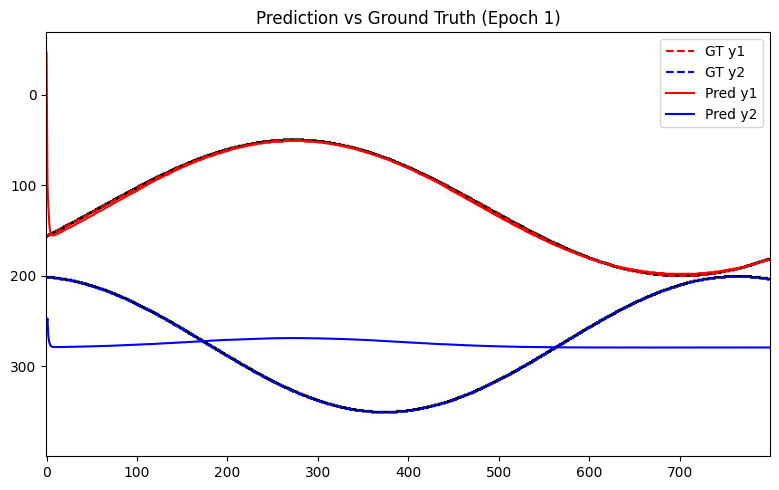

In [5]:
# Visualization of predictions at each epoch
plt.figure(figsize=(12, 5))
plt.imshow(image[0], cmap='gray')
plt.plot(np.arange(W), gt[0, :, 0].numpy() * H, 'r--', label='GT y1')
plt.plot(np.arange(W), gt[0, :, 1].numpy() * H, 'b--', label='GT y2')
plt.plot(np.arange(W), predicted_seq[0, :, 0].detach().numpy() * H, 'r-', label='Pred y1')
plt.plot(np.arange(W), predicted_seq[0, :, 1].detach().numpy() * H, 'b-', label='Pred y2')
plt.legend()
plt.title(f"Prediction vs Ground Truth (Epoch {epoch+1})")
plt.tight_layout()
plt.show()

In [ ]:
# Multi-curve tracking RNN with Hungarian matching

import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from scipy.optimize import linear_sum_assignment
import matplotlib.pyplot as plt
import os
import cv2

# ------------------------
# Load Data (already prepared)
# ------------------------

def load_images_from_folder(folder):
    return np.array([cv2.imread(os.path.join(folder, f), cv2.IMREAD_GRAYSCALE)
                     for f in sorted(os.listdir(folder)) if f.endswith('.jpg')])

def load_ground_truths(folder):
    file_list = sorted([f for f in os.listdir(folder) if f.endswith(".npy")])
    GTs = [np.load(os.path.join(folder, f)) for f in file_list]
    return np.stack(GTs)  # [N, num_curves, W]

# Set your paths here
source_directory = "D:/Courses/Uclouvain/thesis/code/thesis_Colin/seismogram_curve_extraction/data_2_traces/sines/overlap_0-00/"
signals_directory = os.path.join(source_directory, "signals")
gts_directory = os.path.join(source_directory, "ground_truth")

all_images = load_images_from_folder(signals_directory)  # shape [N, H, W]
GTs = load_ground_truths(gts_directory)  # shape [N, C, W]

# ------------------------
# Dataset
# ------------------------

class SeismoTrackingDataset(Dataset):
    def __init__(self, images, gts):
        self.images = images / 255.0
        self.gts = gts

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return torch.tensor(self.images[idx], dtype=torch.float32), torch.tensor(self.gts[idx], dtype=torch.float32)

# ------------------------
# Model
# ------------------------

class RNNTracker(nn.Module):
    def __init__(self, N, d):
        super().__init__()
        self.N, self.d = N, d
        self.input_dim = N
        self.state_dim = N*d

        self.updater = nn.RNN(input_size=self.input_dim, hidden_size=self.state_dim, batch_first=True, nonlinearity="tanh")
        self.output_layer = nn.Linear(self.state_dim, self.N)

    def forward(self, measurement, hidden):
        _, hidden = self.updater(measurement.unsqueeze(0).unsqueeze(0), hidden)
        x = self.output_layer(hidden.squeeze(0))
        return x.squeeze(0), hidden

# ------------------------
# Training Loop
# ------------------------

N = GTs.shape[1]  # number of curves
H, W = all_images.shape[1:]
d = 3 # USER
hidden_size = N*d
lambda_smooth = 0.1 # USER

model = RNNTracker(N=N, d=d)
dataset = SeismoTrackingDataset(all_images, GTs)
train_size = int(0.8 * len(dataset)) # USER
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 10 # USER
train_losses, val_losses = [], []

for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0.0
    for image, gt in train_loader:
        image = image.squeeze(0)  # [H, W]
        gt = gt.squeeze(0)        # [N, W]

        optimizer.zero_grad()
        hidden = torch.zeros(1, 1, hidden_size)
        x = torch.zeros(hidden_size)
        x[:N] = gt[:, 0]  # first positions
        hidden[0, 0] = x

        preds = []
        for t in range(1, W):
            col = image[:, t]
            row_indices = torch.where(col < 0.5)[0].float() # USER
            row_indices = row_indices[:N]
            if len(row_indices) < N:
                row_indices = torch.cat([row_indices, torch.zeros(N - len(row_indices))])
            row_indices = row_indices / H
            
            x_pred = model.output_layer(hidden[0, 0])
            pred_pos = x_pred.unsqueeze(1)
            # Hungarian assignment to match predicted positions with measurements
            with torch.no_grad():
                meas = row_indices.unsqueeze(0)
                cost_matrix = torch.abs(pred_pos - meas).cpu().numpy()
                _, col_ind = linear_sum_assignment(cost_matrix)
                z_sorted = row_indices[col_ind]

            x, hidden = model(z_sorted, hidden)
            preds.append(x)

        preds = torch.stack(preds)  # [T, N]
        target = gt[:, 1:].T
        loss_rmse = torch.sqrt(((preds - target) ** 2).mean())
        loss_smooth = ((preds[1:] - preds[:-1]) ** 2).mean()
        loss = loss_rmse + lambda_smooth * loss_smooth
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    model.eval()
    total_val_loss = 0.0
    with torch.no_grad():
        for image, gt in val_loader:
            image = image.squeeze(0)
            gt = gt.squeeze(0)
            hidden = torch.zeros(1, 1, hidden_size)
            x = torch.zeros(hidden_size)
            x[:N] = gt[:, 0]
            hidden[0, 0] = x

            preds = []
            for t in range(1, W):
                col = image[:, t]
                row_indices = torch.where(col < 0.5)[0].float()
                row_indices = row_indices[:N]
                if len(row_indices) < N:
                    row_indices = torch.cat([row_indices, torch.zeros(N - len(row_indices))])
                row_indices = row_indices / H

                x_pred = model.output_layer(hidden[0, 0])
                pred_pos = x_pred.unsqueeze(1)
                meas = row_indices.unsqueeze(0)
                cost_matrix = torch.abs(pred_pos - meas).cpu().numpy()
                _, col_ind = linear_sum_assignment(cost_matrix)
                z_sorted = row_indices[col_ind]

                x, hidden = model(z_sorted, hidden)
                preds.append(x)

            preds = torch.stack(preds)
            target = gt[:, 1:].T
            loss_rmse = torch.sqrt(((preds - target) ** 2).mean())
            loss_smooth = ((preds[1:] - preds[:-1]) ** 2).mean()
            loss = loss_rmse + lambda_smooth * loss_smooth
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

# Plot final learning curves
plt.figure(figsize=(8, 4))
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# ------------------------
# Visualize predictions on validation sample after each epoch
# ------------------------
model.eval()
with torch.no_grad():
    image, gt = next(iter(val_loader))
    image = image.squeeze(0)
    gt = gt.squeeze(0)
    hidden = torch.zeros(1, 1, hidden_size)
    x = torch.zeros(hidden_size)
    x[:N] = gt[:, 0]
    hidden[0, 0] = x

    preds = []
    for t in range(1, W):
        col = image[:, t]
        row_indices = torch.where(col < 0.5)[0].float()
        row_indices = row_indices[:N]
        if len(row_indices) < N:
            row_indices = torch.cat([row_indices, torch.zeros(N - len(row_indices))])
        row_indices = row_indices / H

        x_pred = model.output_layer(hidden[0, 0])
        pred_pos = x_pred.unsqueeze(1)
        meas = row_indices.unsqueeze(0)
        cost_matrix = torch.abs(pred_pos - meas).cpu().numpy()
        _, col_ind = linear_sum_assignment(cost_matrix)
        z_sorted = row_indices[col_ind]

        x, hidden = model(z_sorted, hidden)
        preds.append(x)

    preds = torch.stack(preds).T * H
    time_axis = np.arange(1, W)

    plt.figure(figsize=(12, 6))
    for i in range(N):
        plt.plot(time_axis, gt[i, 1:].numpy() * H, '--', label=f'GT curve {i}')
        plt.plot(time_axis, preds[i].numpy(), label=f'Pred curve {i}')
    plt.title("Validation Prediction vs Ground Truth")
    plt.xlabel("Time step (image column)")
    plt.ylabel("Pixel row (vertical position)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
